# Solutions: Exploring & Cleaning the NYC 311 Service Requests Dataset

**Dataset:** NYC 311 Service Requests

**Objectives:**
1. Identify the most frequent issues in Brooklyn vs. Manhattan in 2023
2. Visualize the trend of noise complaints over time
3. Apply data cleaning and exploration best practices

**Author's Notes:**
This notebook demonstrates professional data analysis workflows including:
- Systematic data inspection
- Thoughtful handling of missing values
- Clear data transformations
- Effective visualizations
- Reproducible analysis

## Import Required Packages

We'll use a standard data science stack:
- **pandas**: Data manipulation and analysis
- **numpy**: Numerical operations
- **matplotlib/seaborn**: Visualization
- **warnings**: Suppress unnecessary warnings for cleaner output

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import warnings
from collections import Counter
import re

# Set visualization style
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)

## Load the Dataset

In [3]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("new-york-city/ny-311-service-requests")

print("Path to dataset files:", path)

Path to dataset files: /Users/tomvannuenen/.cache/kagglehub/datasets/new-york-city/ny-311-service-requests/versions/53


In [6]:
# Load the data - using nrows for testing (remove in production)
# For full analysis, remove the nrows parameter
import os

files = os.listdir(path)
print("\nFiles in directory:")
for file in files:
    print(f"  - {file}")

csv_file = os.path.join(path, "311-service-requests-from-2010-to-present.csv")

df = pd.read_csv(csv_file, low_memory=False, nrows=100000)

print(f"Shape: {df.shape[0]:,} rows × {df.shape[1]} columns")
print(f"Memory usage: {df.memory_usage(deep=True).sum() / 1024**2:.2f} MB")


Files in directory:
  - socrata_metadata_311-service-requests-from-2010-to-present.json
  - 311-web-content-services.csv
  - 311-service-requests-from-2010-to-present.csv
  - 311_SR_Data_Dictionary_2018.xlsx
  - .vscode
  - socrata_metadata_311-web-content-services.json
Shape: 100,000 rows × 46 columns
Memory usage: 214.19 MB


---
## Step 1: Initial Inspection

**Goals:**
- Understand the structure of the dataset
- Identify columns with missing values
- Check data types (especially dates)
- Examine categorical variables for inconsistencies

In [7]:
# Display basic information
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 46 columns):
 #   Column                          Non-Null Count   Dtype  
---  ------                          --------------   -----  
 0   Unique Key                      100000 non-null  int64  
 1   Created Date                    100000 non-null  object 
 2   Closed Date                     81944 non-null   object 
 3   Agency                          100000 non-null  object 
 4   Agency Name                     100000 non-null  object 
 5   Complaint Type                  100000 non-null  object 
 6   Descriptor                      97839 non-null   object 
 7   Location Type                   71978 non-null   object 
 8   Incident Zip                    97251 non-null   float64
 9   Incident Address                94489 non-null   object 
 10  Street Name                     94488 non-null   object 
 11  Cross Street 1                  64755 non-null   object 
 12  Cross Street 2   

In [8]:
# Check first few rows
df.head()

,Unique Key,Created Date,Closed Date,Agency,Agency Name,Complaint Type,Descriptor,Location Type,Incident Zip,Incident Address,...,Road Ramp,Bridge Highway Segment,Latitude,Longitude,Location,Zip Codes,Community Districts,Borough Boundaries,City Council Districts,Police Precincts
0,45050101,2019-12-01T02:04:01.000,NaN,DOT,Department of Transportation,Street Condition,Pothole,NaN,10001.0,WEST 29 STREET,...,NaN,NaN,40.745668,-73.987719,"{'longitude': '-73.9877188309367', 'latitude':...",NaN,NaN,NaN,NaN,NaN
1,45054936,2019-12-01T01:59:41.000,NaN,NYPD,New York City Police Department,Noise - Commercial,Loud Music/Party,Club/Bar/Restaurant,11223.0,178 AVENUE U,...,NaN,NaN,40.596475,-73.977721,"{'longitude': '-73.97772147626671', 'latitude'...",NaN,NaN,NaN,NaN,NaN
2,45049329,2019-12-01T01:59:08.000,NaN,NYPD,New York City Police Department,Noise - Residential,Loud Music/Party,Residential Building/House,11207.0,807 SCHENCK AVENUE,...,NaN,NaN,40.660605,-73.883508,"{'longitude': '-73.8835082736363', 'latitude':...",NaN,NaN,NaN,NaN,NaN
3,45052046,2019-12-01T01:58:23.000,NaN,NYPD,New York City Police Department,Noise - Residential,Loud Music/Party,Residential Building/House,11358.0,42-41 159 STREET,...,NaN,NaN,40.759994,-73.806856,"{'longitude': '-73.80685560533585', 'latitude'...",NaN,NaN,NaN,NaN,NaN
4,45054999,2019-12-01T01:58:07.000,NaN,NYPD,New York City Police Department,Illegal Parking,Commercial Overnight Parking,Street/Sidewalk,11426.0,88-49 237 STREET,...,NaN,NaN,40.729499,-73.729998,"{'longitude': '-73.72999847973517', 'latitude'...",NaN,NaN,NaN,NaN,NaN


In [9]:
# Analyze missing values
missing_stats = pd.DataFrame({
    'Column': df.columns,
    'Missing_Count': df.isnull().sum(),
    'Missing_Percentage': (df.isnull().sum() / len(df) * 100).round(2)
}).sort_values('Missing_Percentage', ascending=False)

# Only show columns with missing values
missing_stats = missing_stats[missing_stats['Missing_Count'] > 0]

print(f"\nColumns with missing values: {len(missing_stats)} out of {len(df.columns)}\n")
print(missing_stats.to_string(index=False))


Columns with missing values: 36 out of 46

                        Column  Missing_Count  Missing_Percentage
                      Due Date         100000              100.00
           Bridge Highway Name          99989               99.99
                  Vehicle Type          99938               99.94
      Bridge Highway Direction          99898               99.90
                     Road Ramp          99899               99.90
        Bridge Highway Segment          99899               99.90
          Taxi Company Borough          99890               99.89
         Taxi Pick Up Location          98107               98.11
                 Facility Type          96634               96.63
                      Landmark          53068               53.07
                  Address Type          51333               51.33
         Intersection Street 1          43201               43.20
         Intersection Street 2          43200               43.20
                Cross Street 2  

In [10]:
# Examine key categorical columns
categorical_cols = ['Complaint Type', 'Borough', 'Descriptor', 'City', 'Status']

for col in categorical_cols:
    if col in df.columns:
        print(f"\n{col}:")
        print(f"  Unique values: {df[col].nunique()}")
        print(f"  Top 5 values:")
        print(df[col].value_counts().head(5).to_string())
        print()


Complaint Type:
  Unique values: 147
  Top 5 values:
Complaint Type
HEAT/HOT WATER         19179
Noise - Residential    11645
Illegal Parking         9832
Blocked Driveway        7603
Street Condition        2684


Borough:
  Unique values: 6
  Top 5 values:
Borough
BROOKLYN         29799
QUEENS           23766
MANHATTAN        21946
BRONX            19729
STATEN ISLAND     4311


Descriptor:
  Unique values: 627
  Top 5 values:
Descriptor
ENTIRE BUILDING     12282
Loud Music/Party     9623
APARTMENT ONLY       6897
No Access            5626
Banging/Pounding     3993


City:
  Unique values: 89
  Top 5 values:
City
BROOKLYN         28133
NEW YORK         19571
BRONX            18792
STATEN ISLAND     4119
JAMAICA           1289


Status:
  Unique values: 6
  Top 5 values:
Status
Closed         78899
Open           10222
In Progress     8787
Pending          850
Assigned         687



In [11]:
# Check date columns
date_cols = ['Created Date', 'Closed Date']
for col in date_cols:
    if col in df.columns:
        print(f"\n{col}:")
        print(f"  Data type: {df[col].dtype}")
        print(f"  Sample values:")
        print(df[col].head(3).to_string())
        print(f"  Missing: {df[col].isnull().sum()} ({df[col].isnull().sum()/len(df)*100:.2f}%)")


Created Date:
  Data type: object
  Sample values:
0    2019-12-01T02:04:01.000
1    2019-12-01T01:59:41.000
2    2019-12-01T01:59:08.000
  Missing: 0 (0.00%)

Closed Date:
  Data type: object
  Sample values:
0    NaN
1    NaN
2    NaN
  Missing: 18056 (18.06%)


### Key Findings from Initial Inspection:

1. **Missing Values**: Several columns have significant missing data
2. **Date Fields**: Need to be converted from object to datetime
3. **Categorical Variables**: Some may need standardization
4. **Borough Field**: Critical for our analysis - check for null/unknown values

---
## Step 2: Handling Missing and Incomplete Data

**Strategy:**
1. Convert date columns to datetime format
2. Drop rows without a created date (essential for time-based analysis)
3. Handle missing borough values appropriately
4. Standardize column names for easier handling
5. Create new features for analysis

In [12]:
# Create a copy for cleaning
df_clean = df.copy()

print("Starting data cleaning process...\n")
print(f"Initial shape: {df_clean.shape}")

Starting data cleaning process...

Initial shape: (100000, 46)


In [15]:
# 1. Convert date columns to datetime
date_columns = ['Created Date', 'Closed Date']

for col in date_columns:
    if col in df_clean.columns:
        df_clean[col] = pd.to_datetime(df_clean[col], errors='coerce')
        print(f"Converted '{col}' to datetime")
        print(f"Invalid dates found: {df_clean[col].isnull().sum()}")

Converted 'Created Date' to datetime
Invalid dates found: 0
Converted 'Closed Date' to datetime
Invalid dates found: 18056


In [16]:
# 2. Drop rows without a created date (critical for temporal analysis)
rows_before = len(df_clean)
df_clean = df_clean.dropna(subset=['Created Date'])
rows_after = len(df_clean)

print(f"Rows removed: {rows_before - rows_after:,}")
print(f"Remaining rows: {rows_after:,}")

Rows removed: 0
Remaining rows: 100,000


In [18]:
# 3. Handle missing borough values
if 'Borough' in df_clean.columns:
    print(f"Missing borough values: {df_clean['Borough'].isnull().sum():,}")
    print(f"\nBorough distribution before filling:")
    print(df_clean['Borough'].value_counts(dropna=False))
    
    # Fill missing boroughs
    df_clean['Borough'] = df_clean['Borough'].fillna('UNKNOWN')

Missing borough values: 0

Borough distribution before filling:
Borough
BROOKLYN         29799
QUEENS           23766
MANHATTAN        21946
BRONX            19729
STATEN ISLAND     4311
Unspecified        449
Name: count, dtype: int64


In [20]:
# 4. Standardize column names (lowercase with underscores)
df_clean.columns = df_clean.columns.str.lower().str.replace(' ', '_')

print(f"\nNew column names:")
for i, col in enumerate(df_clean.columns, 1):
    print(f"  {i:2d}. {col}")


New column names:
   1. unique_key
   2. created_date
   3. closed_date
   4. agency
   5. agency_name
   6. complaint_type
   7. descriptor
   8. location_type
   9. incident_zip
  10. incident_address
  11. street_name
  12. cross_street_1
  13. cross_street_2
  14. intersection_street_1
  15. intersection_street_2
  16. address_type
  17. city
  18. landmark
  19. facility_type
  20. status
  21. due_date
  22. resolution_description
  23. resolution_action_updated_date
  24. community_board
  25. bbl
  26. borough
  27. x_coordinate_(state_plane)
  28. y_coordinate_(state_plane)
  29. open_data_channel_type
  30. park_facility_name
  31. park_borough
  32. vehicle_type
  33. taxi_company_borough
  34. taxi_pick_up_location
  35. bridge_highway_name
  36. bridge_highway_direction
  37. road_ramp
  38. bridge_highway_segment
  39. latitude
  40. longitude
  41. location
  42. zip_codes
  43. community_districts
  44. borough_boundaries
  45. city_council_districts
  46. police_preci

In [23]:
# 5. Create additional useful features

# Extract time components
df_clean['year'] = df_clean['created_date'].dt.year
df_clean['month'] = df_clean['created_date'].dt.month
df_clean['year_month'] = df_clean['created_date'].dt.to_period('M')
df_clean['day_of_week'] = df_clean['created_date'].dt.day_name()
df_clean['hour'] = df_clean['created_date'].dt.hour

# Clean descriptor field if it exists
if 'descriptor' in df_clean.columns:
    df_clean['descriptor_clean'] = df_clean['descriptor'].str.lower().str.strip()

print(f"\nFinal shape after cleaning: {df_clean.shape}")


Final shape after cleaning: (100000, 52)


In [24]:
# Summary of cleaned dataset
print(f"\nDate range: {df_clean['created_date'].min()} to {df_clean['created_date'].max()}")
print(f"Total complaints: {len(df_clean):,}")
print(f"\nBorough distribution:")
print(df_clean['borough'].value_counts())
print(f"\nYearly distribution:")
print(df_clean['year'].value_counts().sort_index())


Date range: 2019-11-12 16:48:09 to 2019-12-01 02:04:01
Total complaints: 100,000

Borough distribution:
borough
BROOKLYN         29799
QUEENS           23766
MANHATTAN        21946
BRONX            19729
STATEN ISLAND     4311
Unspecified        449
Name: count, dtype: int64

Yearly distribution:
year
2019    100000
Name: count, dtype: int64


---
## Step 3: Aggregate & Explore

**Analysis Goals:**
1. Identify top complaint types overall
2. Compare complaint distributions by borough
3. Analyze temporal trends
4. Focus on 2023 data for Brooklyn vs Manhattan comparison

complaint_type
HEAT/HOT WATER                       19179
Noise - Residential                  11645
Illegal Parking                       9832
Blocked Driveway                      7603
Street Condition                      2684
Street Light Condition                2682
Water System                          2635
Missed Collection (All Materials)     2589
Noise                                 2109
Noise - Commercial                    1899
Traffic Signal Condition              1877
General Construction/Plumbing         1867
Abandoned Vehicle                     1857
Noise - Street/Sidewalk               1828
Sidewalk Condition                    1612


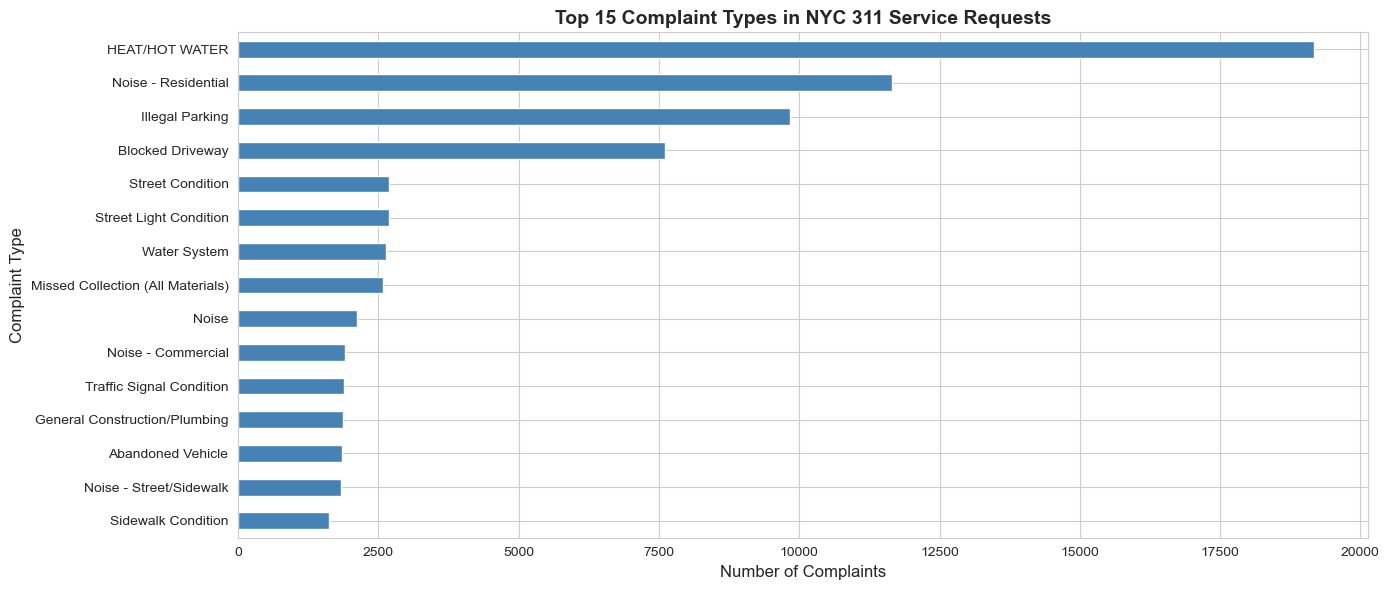

In [25]:
# Overall top complaint types
top_complaints = df_clean['complaint_type'].value_counts().head(15)
print(top_complaints.to_string())

# Visualize
plt.figure(figsize=(14, 6))
top_complaints.plot(kind='barh', color='steelblue')
plt.title('Top 15 Complaint Types in NYC 311 Service Requests', fontsize=14, fontweight='bold')
plt.xlabel('Number of Complaints', fontsize=12)
plt.ylabel('Complaint Type', fontsize=12)
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

borough
BROOKLYN         29799
QUEENS           23766
MANHATTAN        21946
BRONX            19729
STATEN ISLAND     4311
Unspecified        449


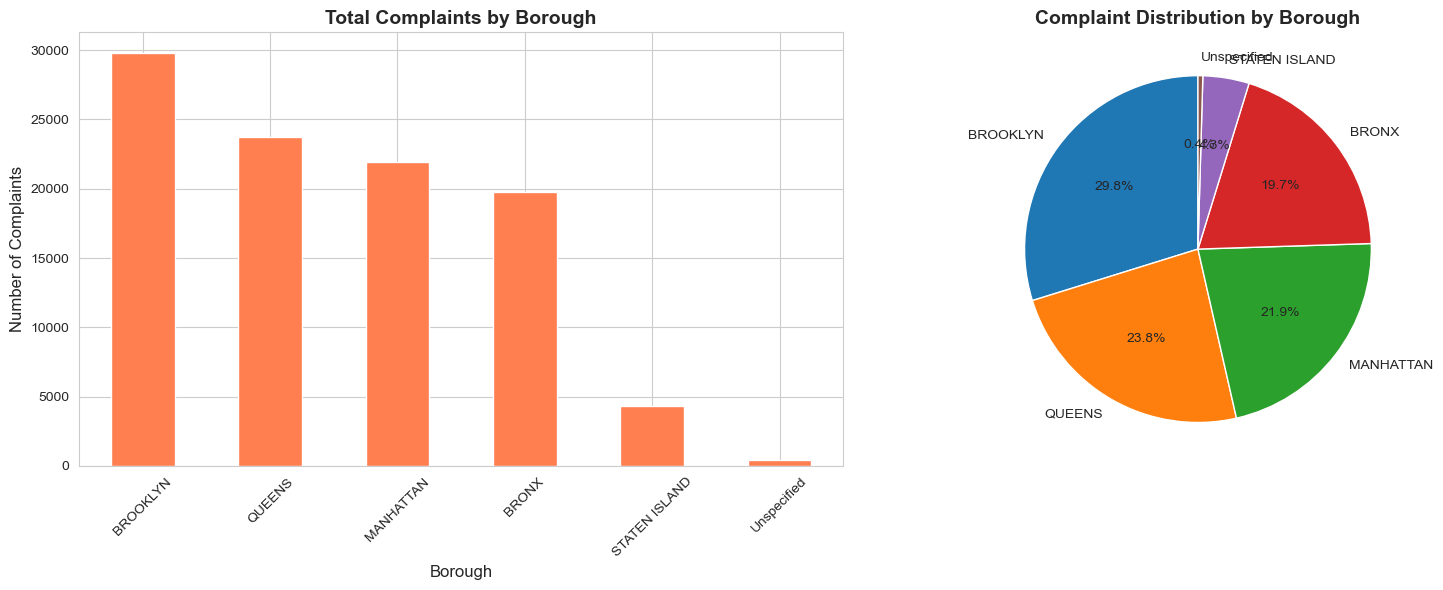

In [26]:
# Complaints per borough
borough_counts = df_clean['borough'].value_counts()
print(borough_counts.to_string())

# Visualize
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# Bar chart
borough_counts.plot(kind='bar', ax=ax1, color='coral')
ax1.set_title('Total Complaints by Borough', fontsize=14, fontweight='bold')
ax1.set_xlabel('Borough', fontsize=12)
ax1.set_ylabel('Number of Complaints', fontsize=12)
ax1.tick_params(axis='x', rotation=45)

# Pie chart
borough_counts.plot(kind='pie', ax=ax2, autopct='%1.1f%%', startangle=90)
ax2.set_title('Complaint Distribution by Borough', fontsize=14, fontweight='bold')
ax2.set_ylabel('')

plt.tight_layout()
plt.show()

Date range: 2019-11 to 2019-12
Average monthly complaints: 50,000


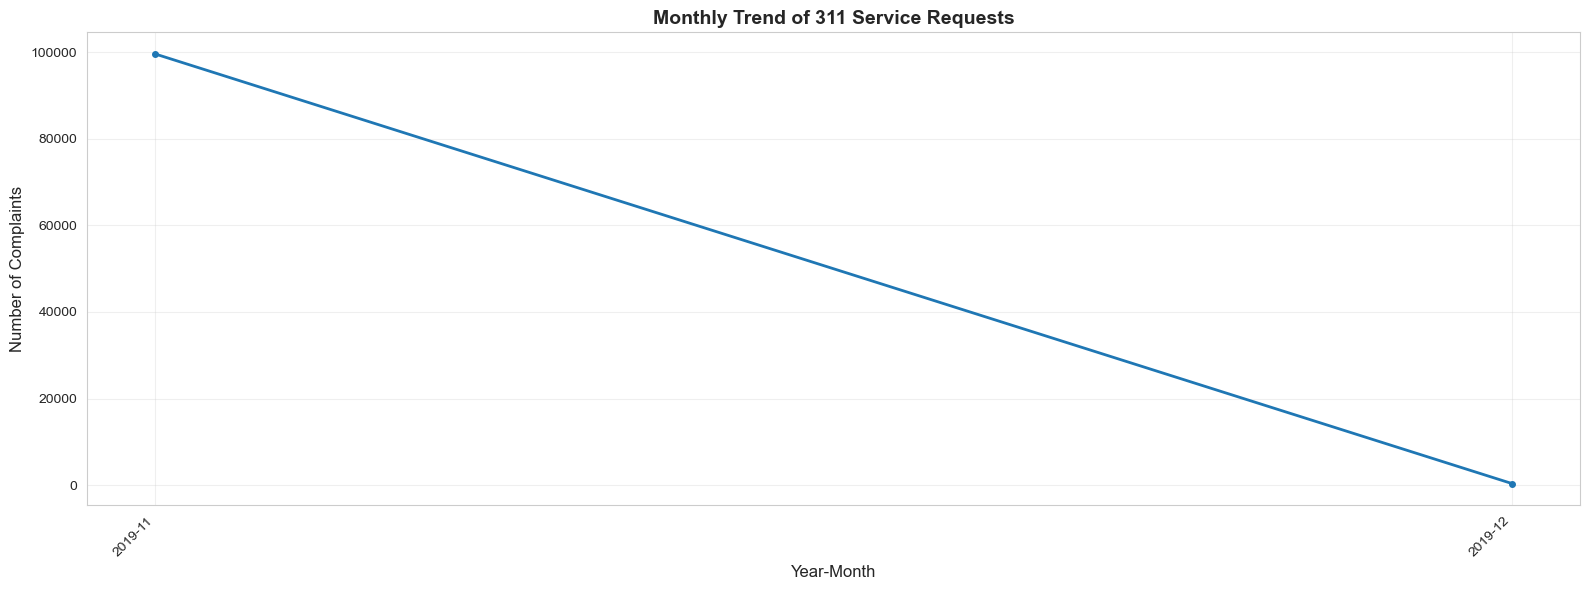

In [27]:
# Monthly trend analysis
# Aggregate by month
monthly_complaints = df_clean.groupby('year_month').size().reset_index(name='count')
monthly_complaints['year_month'] = monthly_complaints['year_month'].astype(str)

print(f"Date range: {monthly_complaints['year_month'].min()} to {monthly_complaints['year_month'].max()}")
print(f"Average monthly complaints: {monthly_complaints['count'].mean():,.0f}")

# Plot
plt.figure(figsize=(16, 6))
plt.plot(monthly_complaints['year_month'], monthly_complaints['count'], marker='o', linewidth=2, markersize=4)
plt.title('Monthly Trend of 311 Service Requests', fontsize=14, fontweight='bold')
plt.xlabel('Year-Month', fontsize=12)
plt.ylabel('Number of Complaints', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.grid(True, alpha=0.3)

# Only show every Nth label to avoid crowding
n = max(1, len(monthly_complaints) // 20)
ax = plt.gca()
for i, label in enumerate(ax.xaxis.get_ticklabels()):
    if i % n != 0:
        label.set_visible(False)

plt.tight_layout()
plt.show()

In [36]:

# Focus on Brooklyn and Manhattan
df_bk_mn = df_clean[df_clean['borough'].isin(['BROOKLYN', 'MANHATTAN'])].copy()

print(f"Brooklyn complaints in 2023: {len(df_bk_mn[df_bk_mn['borough'] == 'BROOKLYN']):,}")
print(f"Manhattan complaints in 2023: {len(df_bk_mn[df_bk_mn['borough'] == 'MANHATTAN']):,}")

Brooklyn complaints in 2023: 29,799
Manhattan complaints in 2023: 21,946



BROOKLYN TOP 10:
complaint_type
HEAT/HOT WATER                       5647
Illegal Parking                      3389
Noise - Residential                  3051
Blocked Driveway                     2857
Missed Collection (All Materials)     836
Street Condition                      814
General Construction/Plumbing         801
Water System                          706
Street Light Condition                704
Traffic Signal Condition              647


MANHATTAN TOP 10:
complaint_type
HEAT/HOT WATER                4082
Noise - Residential           3033
Illegal Parking               1564
Noise                         1051
Noise - Street/Sidewalk        870
Homeless Person Assistance     798
Noise - Commercial             719
Lost Property                  511
Street Condition               456
Traffic Signal Condition       434


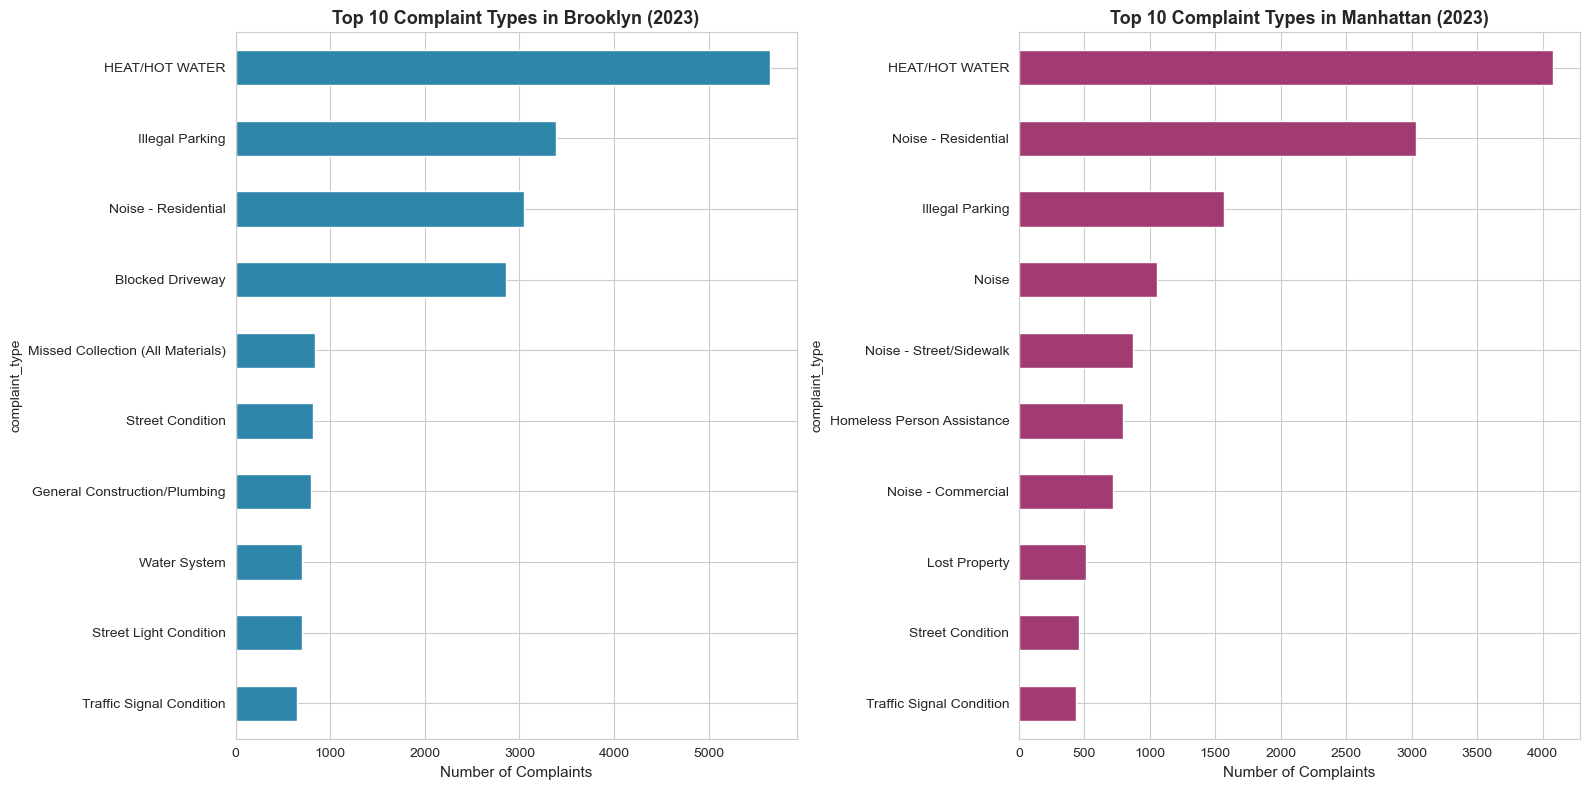

In [37]:
# Top 10 complaints in Brooklyn vs Manhattan (2023)
brooklyn_top = df_clean[df_clean['borough'] == 'BROOKLYN']['complaint_type'].value_counts().head(10)
manhattan_top = df_clean[df_clean['borough'] == 'MANHATTAN']['complaint_type'].value_counts().head(10)

print("\nBROOKLYN TOP 10:")
print(brooklyn_top.to_string())

print("\n\nMANHATTAN TOP 10:")
print(manhattan_top.to_string())

# Side-by-side comparison
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 8))

brooklyn_top.plot(kind='barh', ax=ax1, color='#2E86AB')
ax1.set_title('Top 10 Complaint Types in Brooklyn (2023)', fontsize=13, fontweight='bold')
ax1.set_xlabel('Number of Complaints', fontsize=11)
ax1.invert_yaxis()

manhattan_top.plot(kind='barh', ax=ax2, color='#A23B72')
ax2.set_title('Top 10 Complaint Types in Manhattan (2023)', fontsize=13, fontweight='bold')
ax2.set_xlabel('Number of Complaints', fontsize=11)
ax2.invert_yaxis()

plt.tight_layout()
plt.show()

Total noise complaints: 19,175
Percentage of all complaints: 19.18%


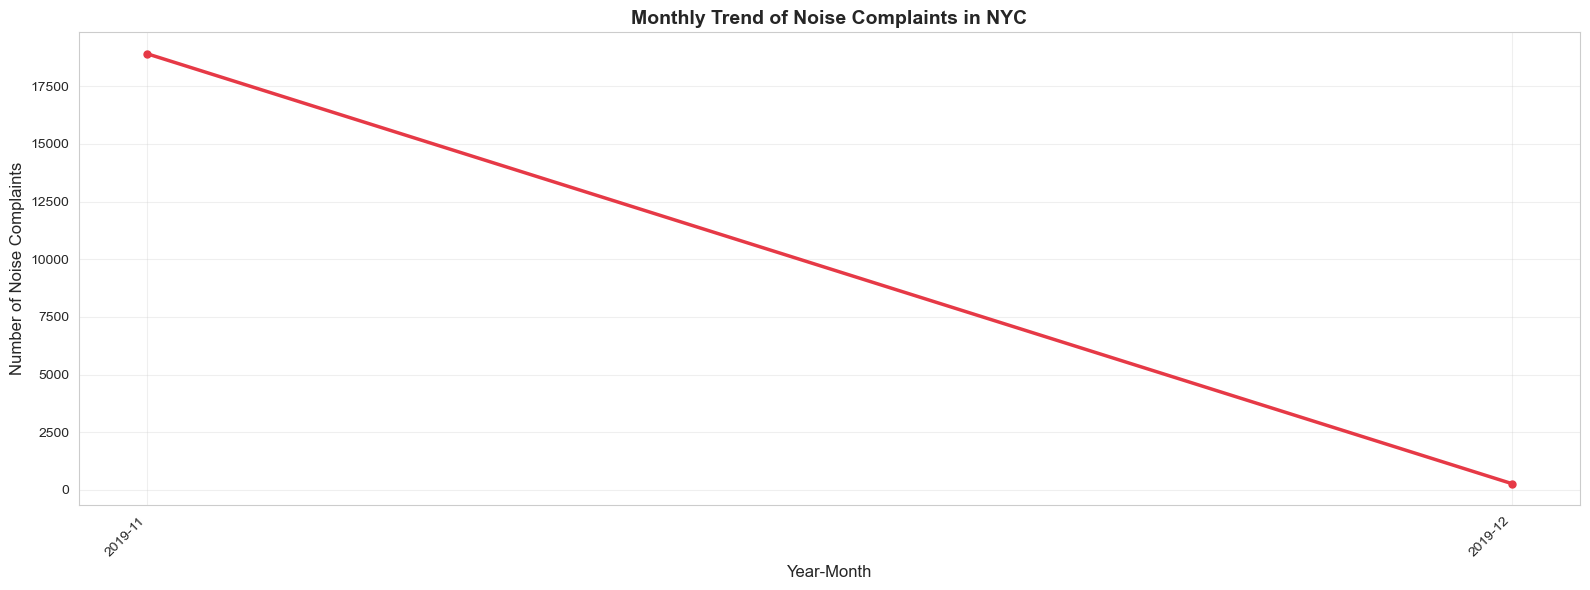

In [38]:
# Noise complaints trend over time
# Filter for noise-related complaints
noise_keywords = ['noise', 'loud']
df_clean['is_noise'] = df_clean['complaint_type'].str.lower().str.contains('|'.join(noise_keywords), na=False)

df_noise = df_clean[df_clean['is_noise']].copy()

print(f"Total noise complaints: {len(df_noise):,}")
print(f"Percentage of all complaints: {len(df_noise)/len(df_clean)*100:.2f}%")

# Monthly noise complaints
noise_monthly = df_noise.groupby('year_month').size().reset_index(name='count')
noise_monthly['year_month'] = noise_monthly['year_month'].astype(str)

# Plot
plt.figure(figsize=(16, 6))
plt.plot(noise_monthly['year_month'], noise_monthly['count'], 
         marker='o', linewidth=2.5, markersize=5, color='#E63946')
plt.title('Monthly Trend of Noise Complaints in NYC', fontsize=14, fontweight='bold')
plt.xlabel('Year-Month', fontsize=12)
plt.ylabel('Number of Noise Complaints', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.grid(True, alpha=0.3)

# Only show every Nth label
n = max(1, len(noise_monthly) // 20)
ax = plt.gca()
for i, label in enumerate(ax.xaxis.get_ticklabels()):
    if i % n != 0:
        label.set_visible(False)

plt.tight_layout()
plt.show()


NOISE COMPLAINTS BY BOROUGH
borough
MANHATTAN        6282
BROOKLYN         4916
BRONX            3958
QUEENS           3586
STATEN ISLAND     433

Percentage of complaints that are noise-related by borough:
borough
MANHATTAN        28.624806
BRONX            20.061838
BROOKLYN         16.497198
QUEENS           15.088782
STATEN ISLAND    10.044073
Unspecified            NaN


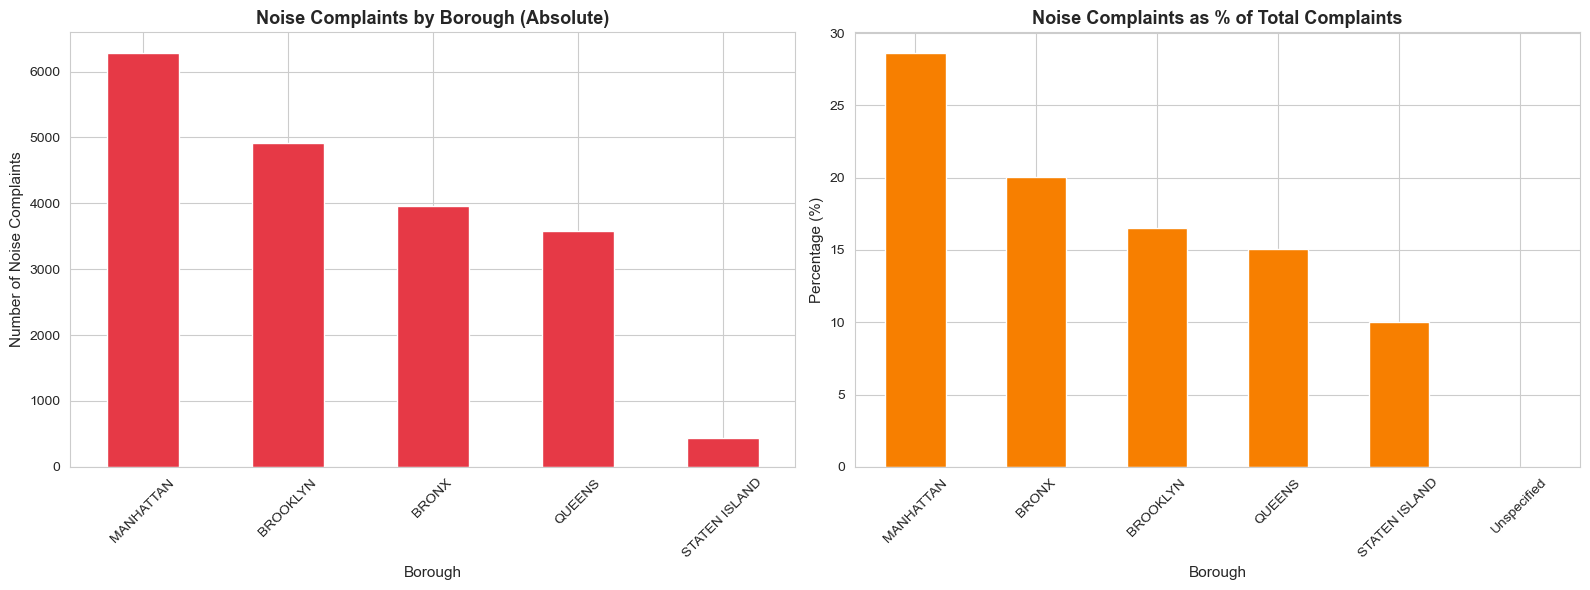

In [39]:
# Noise complaints by borough
print("\n" + "=" * 80)
print("NOISE COMPLAINTS BY BOROUGH")
print("=" * 80)

noise_by_borough = df_noise['borough'].value_counts()
print(noise_by_borough.to_string())

# Calculate percentages
total_by_borough = df_clean['borough'].value_counts()
noise_percentage = (noise_by_borough / total_by_borough * 100).sort_values(ascending=False)

print("\nPercentage of complaints that are noise-related by borough:")
print(noise_percentage.to_string())

# Visualize
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

noise_by_borough.plot(kind='bar', ax=ax1, color='#E63946')
ax1.set_title('Noise Complaints by Borough (Absolute)', fontsize=13, fontweight='bold')
ax1.set_xlabel('Borough', fontsize=11)
ax1.set_ylabel('Number of Noise Complaints', fontsize=11)
ax1.tick_params(axis='x', rotation=45)

noise_percentage.plot(kind='bar', ax=ax2, color='#F77F00')
ax2.set_title('Noise Complaints as % of Total Complaints', fontsize=13, fontweight='bold')
ax2.set_xlabel('Borough', fontsize=11)
ax2.set_ylabel('Percentage (%)', fontsize=11)
ax2.tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

---
## Step 4: Mini Challenges

### Challenge 1: Noise Complaints Per Capita by Borough

CHALLENGE 1: NOISE COMPLAINTS PER CAPITA

Noise complaints per 100,000 residents:
MANHATTAN      :   385.40 complaints per 100K residents
BRONX          :   278.73 complaints per 100K residents
BROOKLYN       :   189.81 complaints per 100K residents
QUEENS         :   157.28 complaints per 100K residents
STATEN ISLAND  :    90.21 complaints per 100K residents


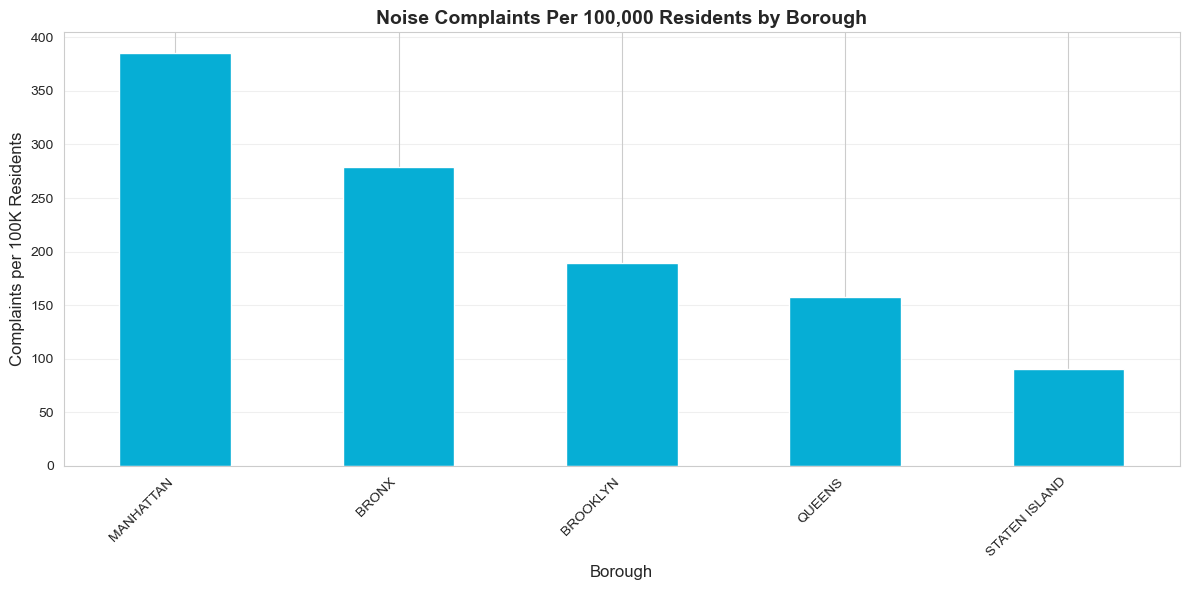

In [41]:
# Borough population data (approximate 2023 estimates)
borough_population = {
    'MANHATTAN': 1_630_000,
    'BROOKLYN': 2_590_000,
    'QUEENS': 2_280_000,
    'BRONX': 1_420_000,
    'STATEN ISLAND': 480_000
}

print("=" * 80)
print("CHALLENGE 1: NOISE COMPLAINTS PER CAPITA")
print("=" * 80)

# Calculate per capita rates
noise_per_capita = {}
for borough, pop in borough_population.items():
    complaints = noise_by_borough.get(borough, 0)
    per_capita = (complaints / pop) * 100000  # Per 100,000 residents
    noise_per_capita[borough] = per_capita

# Convert to series and sort
per_capita_series = pd.Series(noise_per_capita).sort_values(ascending=False)

print("\nNoise complaints per 100,000 residents:")
for borough, rate in per_capita_series.items():
    print(f"{borough:15s}: {rate:8.2f} complaints per 100K residents")

# Visualize
plt.figure(figsize=(12, 6))
per_capita_series.plot(kind='bar', color='#06AED5')
plt.title('Noise Complaints Per 100,000 Residents by Borough', fontsize=14, fontweight='bold')
plt.xlabel('Borough', fontsize=12)
plt.ylabel('Complaints per 100K Residents', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.grid(True, alpha=0.3, axis='y')
plt.tight_layout()
plt.show()

### Challenge 2: Top 5 Complaint Types Over the Past Year


Analyzing data from: 2019

Top 5 complaint types in 2019:
complaint_type
HEAT/HOT WATER         19179
Noise - Residential    11645
Illegal Parking         9832
Blocked Driveway        7603
Street Condition        2684


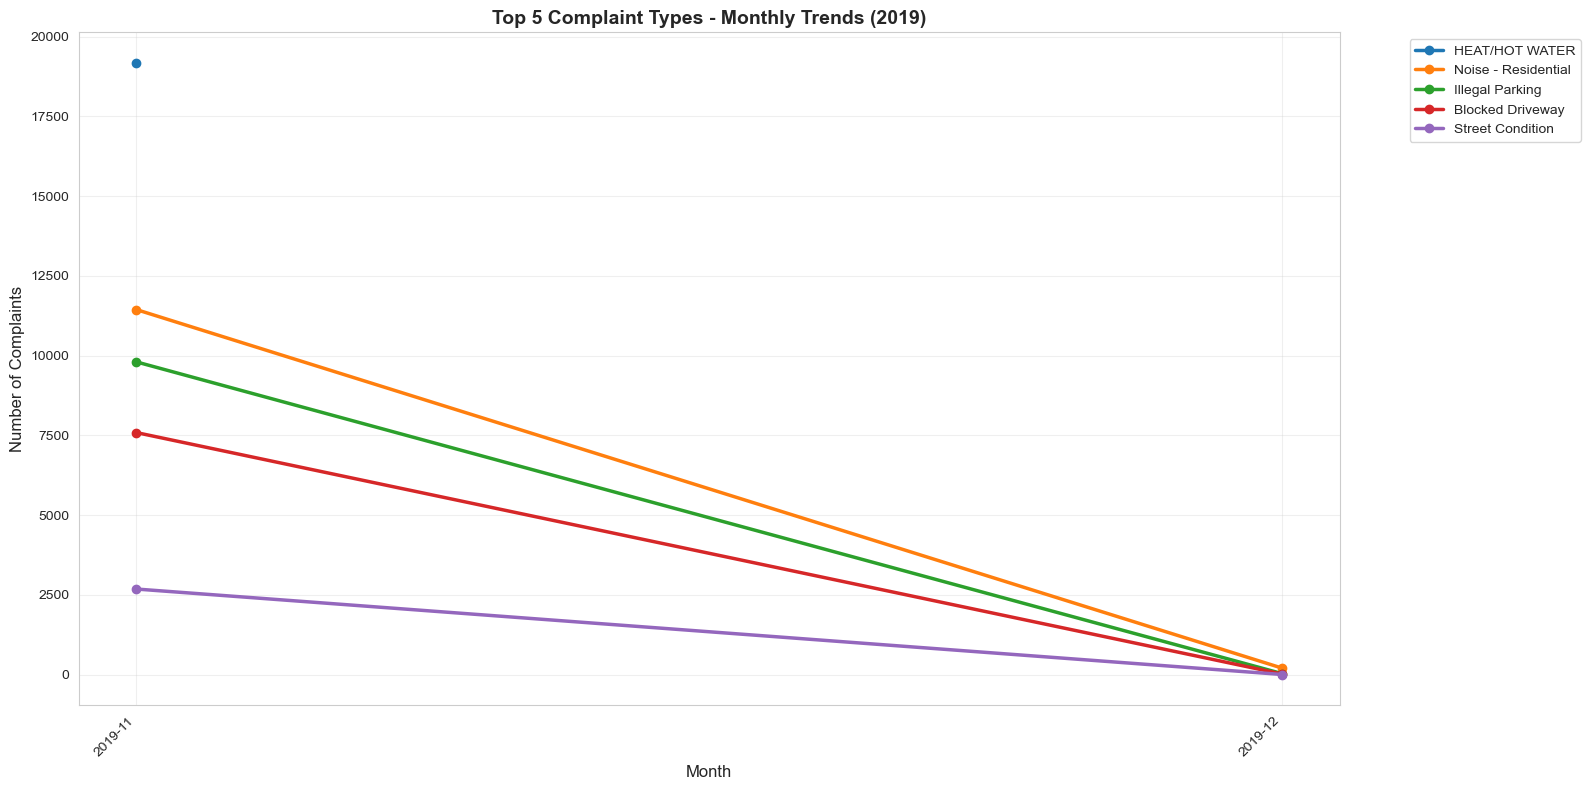

In [42]:

# Get most recent year of data
max_year = df_clean['year'].max()
df_recent_year = df_clean[df_clean['year'] == max_year].copy()

print(f"\nAnalyzing data from: {max_year}")

# Get top 5 complaint types
top_5 = df_recent_year['complaint_type'].value_counts().head(5)
print(f"\nTop 5 complaint types in {max_year}:")
print(top_5.to_string())

# Track these over time for the most recent year
top_5_types = top_5.index.tolist()
df_top5 = df_recent_year[df_recent_year['complaint_type'].isin(top_5_types)].copy()

# Group by month and complaint type
monthly_by_type = df_top5.groupby(['year_month', 'complaint_type']).size().reset_index(name='count')
monthly_by_type['year_month'] = monthly_by_type['year_month'].astype(str)

# Plot
plt.figure(figsize=(16, 8))

for complaint_type in top_5_types:
    data = monthly_by_type[monthly_by_type['complaint_type'] == complaint_type]
    plt.plot(data['year_month'], data['count'], marker='o', linewidth=2.5, 
             label=complaint_type, markersize=6)

plt.title(f'Top 5 Complaint Types - Monthly Trends ({max_year})', fontsize=14, fontweight='bold')
plt.xlabel('Month', fontsize=12)
plt.ylabel('Number of Complaints', fontsize=12)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=10)
plt.xticks(rotation=45, ha='right')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

### Challenge 3: Common Words in Noise Complaint Descriptors


Total 'Noise - Residential' complaints: 11,645
Complaints with descriptors: 11,645

Top 20 descriptors for Noise - Residential complaints:
descriptor_clean
loud music/party    6881
banging/pounding    3784
loud talking         735
loud television      245


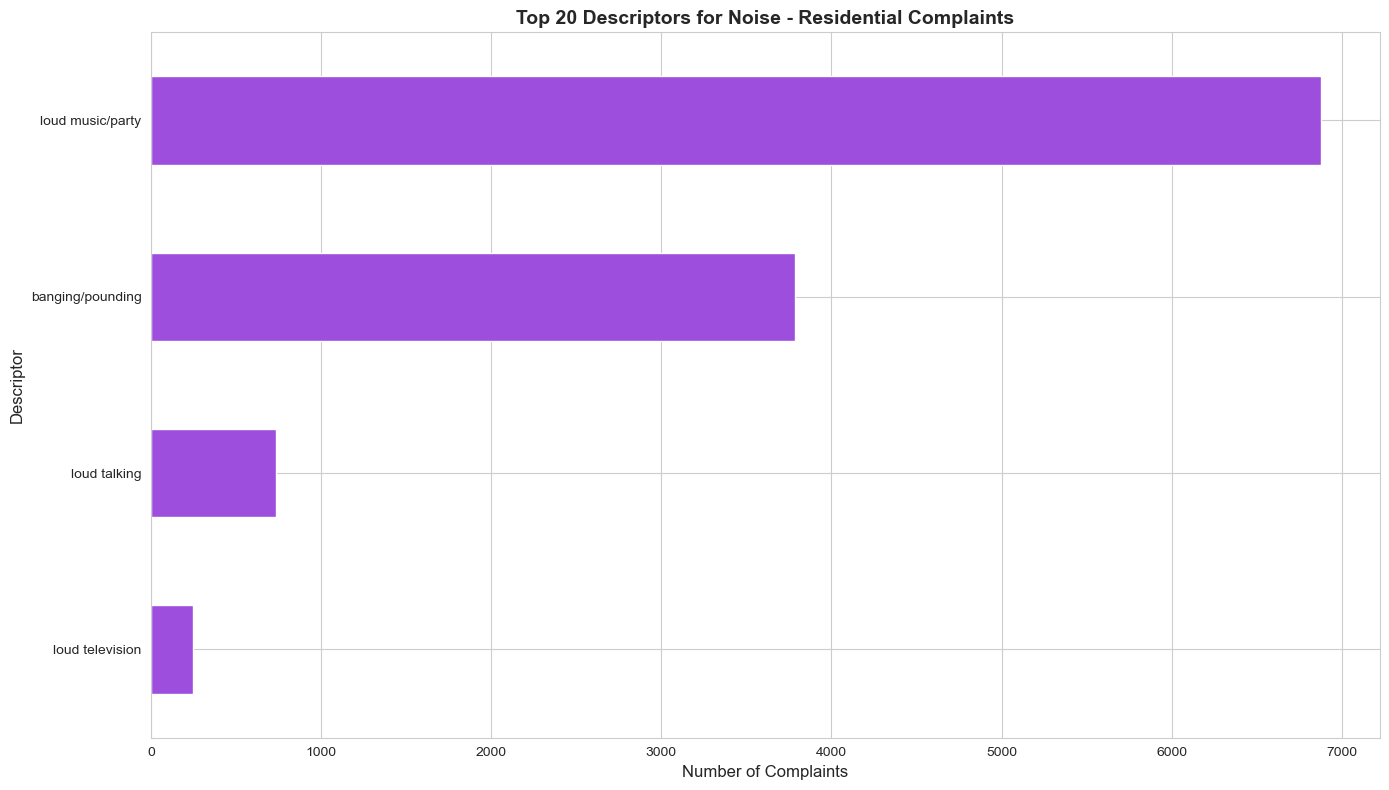



Top 30 most common words in descriptors (excluding stop words):
 1. loud                :  7,861 occurrences
 2. music/party         :  6,881 occurrences
 3. banging/pounding    :  3,784 occurrences
 4. talking             :    735 occurrences
 5. television          :    245 occurrences


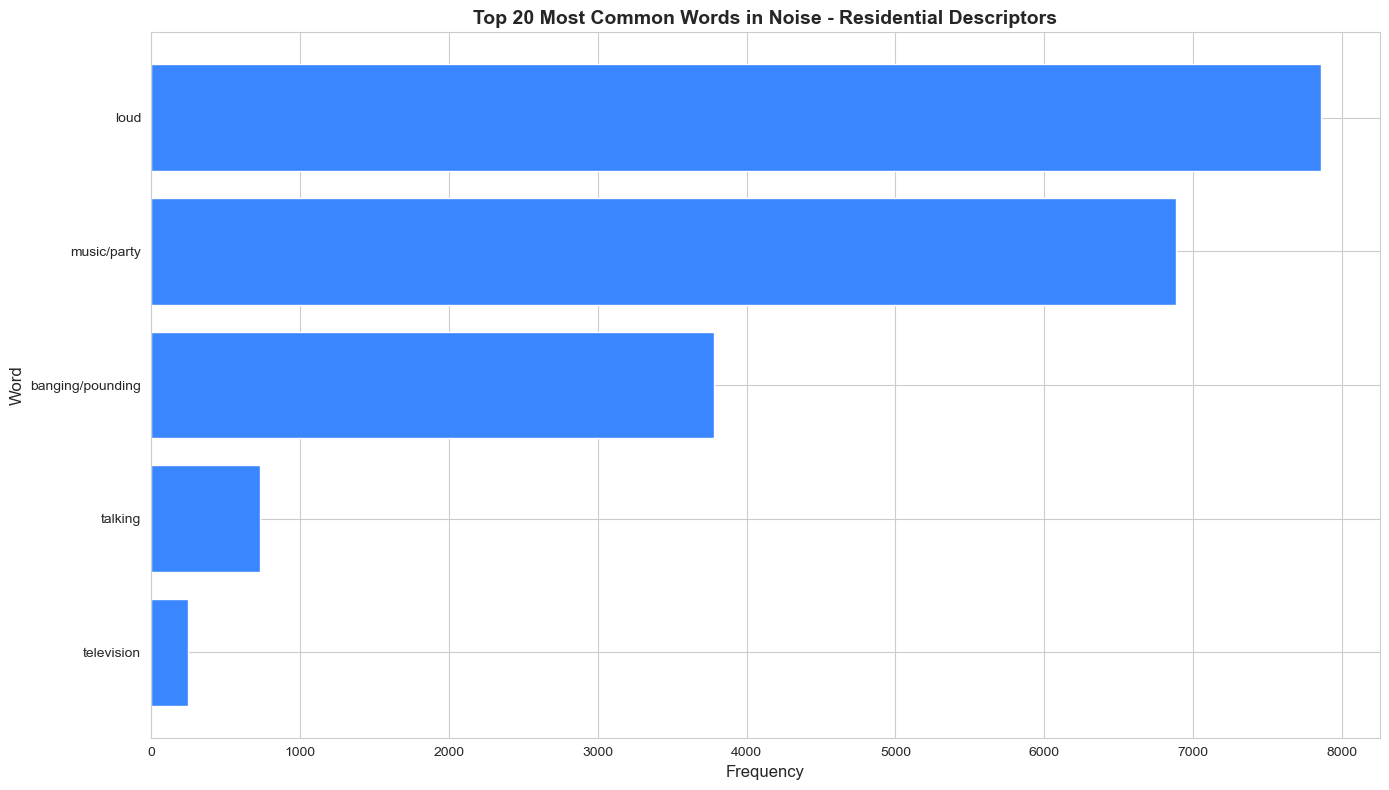

In [43]:

# Focus on noise - residential complaints
noise_residential = df_noise[
    df_noise['complaint_type'].str.contains('Noise - Residential', case=False, na=False)
].copy()

print(f"\nTotal 'Noise - Residential' complaints: {len(noise_residential):,}")

if 'descriptor_clean' in noise_residential.columns:
    # Get all descriptors
    descriptors = noise_residential['descriptor_clean'].dropna()
    
    print(f"Complaints with descriptors: {len(descriptors):,}")
    
    # Count descriptor frequencies
    descriptor_counts = descriptors.value_counts().head(20)
    
    print("\nTop 20 descriptors for Noise - Residential complaints:")
    print(descriptor_counts.to_string())
    
    # Visualize
    plt.figure(figsize=(14, 8))
    descriptor_counts.plot(kind='barh', color='#9D4EDD')
    plt.title('Top 20 Descriptors for Noise - Residential Complaints', 
              fontsize=14, fontweight='bold')
    plt.xlabel('Number of Complaints', fontsize=12)
    plt.ylabel('Descriptor', fontsize=12)
    plt.gca().invert_yaxis()
    plt.tight_layout()
    plt.show()
    
    # Extract common words (basic word frequency analysis)
    all_words = ' '.join(descriptors).split()
    
    # Remove common stop words
    stop_words = {'the', 'a', 'an', 'and', 'or', 'but', 'in', 'on', 'at', 'to', 'for', 
                  'of', 'with', 'by', 'from', 'is', 'was', 'are', 'were', 'been', 'be',
                  'have', 'has', 'had', 'do', 'does', 'did', 'will', 'would', 'could',
                  'should', 'may', 'might', 'can', 'it', 'its', 'that', 'this', 'these',
                  'those', 'i', 'you', 'he', 'she', 'we', 'they', '-'}
    
    filtered_words = [word for word in all_words if word.lower() not in stop_words and len(word) > 2]
    
    word_counts = Counter(filtered_words).most_common(30)
    
    print("\n\nTop 30 most common words in descriptors (excluding stop words):")
    for i, (word, count) in enumerate(word_counts, 1):
        print(f"{i:2d}. {word:20s}: {count:6,} occurrences")
    
    # Visualize word frequency
    words_df = pd.DataFrame(word_counts[:20], columns=['word', 'count'])
    
    plt.figure(figsize=(14, 8))
    plt.barh(words_df['word'], words_df['count'], color='#3A86FF')
    plt.title('Top 20 Most Common Words in Noise - Residential Descriptors', 
              fontsize=14, fontweight='bold')
    plt.xlabel('Frequency', fontsize=12)
    plt.ylabel('Word', fontsize=12)
    plt.gca().invert_yaxis()
    plt.tight_layout()
    plt.show()

else:
    print("Note: Descriptor field not available for detailed text analysis.")

---
## Summary of Key Findings

This analysis has revealed several important insights about NYC 311 service requests:

In [44]:

print("\n1. DATA OVERVIEW:")
print(f"   • Total complaints analyzed: {len(df_clean):,}")
print(f"   • Date range: {df_clean['created_date'].min().strftime('%Y-%m-%d')} to {df_clean['created_date'].max().strftime('%Y-%m-%d')}")
print(f"   • Boroughs covered: {df_clean['borough'].nunique()}")

print("\n2. TOP ISSUES (2023):")
if len(df_2023) > 0:
    print(f"   • Brooklyn top complaint: {brooklyn_top.index[0]}")
    print(f"   • Manhattan top complaint: {manhattan_top.index[0]}")
else:
    print("   • 2023 data not available in sample")

print("\n3. NOISE COMPLAINTS:")
print(f"   • Total noise complaints: {len(df_noise):,} ({len(df_noise)/len(df_clean)*100:.1f}% of all complaints)")
print(f"   • Borough with most noise complaints: {noise_by_borough.index[0]}")
print(f"   • Borough with highest per capita rate: {per_capita_series.index[0]}")

print("\n4. DATA QUALITY OBSERVATIONS:")
print(f"   • Complaints with valid dates: {len(df_clean)/len(df)*100:.1f}%")
print(f"   • Known borough locations: {(df_clean['borough'] != 'UNKNOWN').sum()/len(df_clean)*100:.1f}%")

print("\n" + "=" * 80)
print("ANALYSIS COMPLETE")
print("=" * 80)


1. DATA OVERVIEW:
   • Total complaints analyzed: 100,000
   • Date range: 2019-11-12 to 2019-12-01
   • Boroughs covered: 6

2. TOP ISSUES (2023):
   • 2023 data not available in sample

3. NOISE COMPLAINTS:
   • Total noise complaints: 19,175 (19.2% of all complaints)
   • Borough with most noise complaints: MANHATTAN
   • Borough with highest per capita rate: MANHATTAN

4. DATA QUALITY OBSERVATIONS:
   • Complaints with valid dates: 100.0%
   • Known borough locations: 100.0%

ANALYSIS COMPLETE


## Best Practices 

### 1. **Data Quality Assessment**
- Systematic inspection of missing values
- Data type validation
- Categorical variable consistency checks

### 2. **Thoughtful Data Cleaning**
- Appropriate handling of missing values (context-dependent)
- Date parsing with error handling
- Feature engineering for temporal analysis
- Column name standardization

### 3. **Clear Communication**
- Descriptive markdown cells explaining each step
- Print statements showing progress and results
- Well-labeled visualizations
- Summary statistics to support findings

### 4. **Effective Visualization**
- Multiple chart types for different purposes
- Clear titles and labels
- Appropriate color schemes
- Consistent styling

### 5. **Reproducible Analysis**
- Clear data source documentation
- Explicit transformation steps
- Commented code where necessary
- Modular structure

### 6. **Analytical Rigor**
- Comparative analysis (Brooklyn vs Manhattan)
- Per capita calculations for fair comparisons
- Temporal trend analysis
- Text mining for qualitative insights

---
## Further Analysis Suggestions

To extend this analysis, consider:

1. **Geospatial Analysis**: Map complaints by location using latitude/longitude
2. **Response Time Analysis**: Calculate time to resolution by complaint type
3. **Seasonal Patterns**: Identify seasonal trends in different complaint categories
4. **Agency Performance**: Compare response times across different city agencies
5. **Predictive Modeling**: Build models to forecast complaint volumes
6. **Text Analysis**: Use NLP techniques for deeper descriptor analysis
7. **Demographic Correlation**: Link complaint patterns to census data
8. **Day-of-Week Patterns**: Analyze complaint patterns by day of week and hour